# Import Image Data and Generate FSM

In this notebook, I will import my images using Keras image generator and then create a first simple model using a sequential CNN with one hidden layer.  

### Imports

In [1]:
# imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# turn off warnings
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = FutureWarning)

# modelling
from keras.models import Sequential
from keras.layers import Dense, Flatten

# variable to root directory
parent_dir = '../../'

Using TensorFlow backend.


In [2]:
# create data generator object
datagen = ImageDataGenerator(validation_split = 0.2)

In [3]:
# import data
train_gen = datagen.flow_from_directory(parent_dir + 'data/seg_train/',
                                         batch_size = 64, subset = 'training')

val_gen = datagen.flow_from_directory(parent_dir + 'data/seg_train/', 
                                     batch_size = 64, subset = 'validation')
test_gen = datagen.flow_from_directory(parent_dir + 'data/seg_test/', 
                                        batch_size = 64)

Found 8986 images belonging to 6 classes.
Found 2244 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [4]:
image_, label_ = next(train_gen)

In [5]:
label_.shape

(64, 6)

In [6]:
path = parent_dir + 'data/seg_train/forest'
training_images = os.listdir(path)
training_array = []
for idx, image in enumerate(training_images):
    
    image_single_import = os.path.join(path, training_images[idx])
  
    image = Image.open(image_single_import)
    pixel  = np.asarray(image)
    training_array.append(pixel)

In [7]:
pixel.shape

(150, 150, 3)

In [8]:
train_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

This is the result we expected so we assume this was done correctly.  

Check the shape of the datasets:

## FSM:  Basic CNN Model

### Metric Discussion

Our aim for this model is that it classifies images as accurately as possible.  There is no real preference towards seeing less false negatives over false positives and visa versa since both means that it was a mis-classification either way, which we don't want.  For this reason, we will choose to optimise for accuracy.  

In [18]:
# create sequential model object:
fsm = Sequential()

# flatten shape to 100x100
fsm.add(Flatten(input_shape = (256, 256, 3)))

# create input layer:
fsm.add(Dense(units = 64, activation = 'relu', input_shape = (256, 3)))

# create 1 hidden layer:
fsm.add(Dense(units = 128, activation = 'relu'))

# create output layer:
fsm.add(Dense(units = 6, activation = 'softmax'))

# compile the model:
fsm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [19]:
fsm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 774       
Total params: 12,592,070
Trainable params: 12,592,070
Non-trainable params: 0
_________________________________________________________________


In [20]:
fsm_results = fsm.fit_generator(train_gen, epochs = 4, validation_data = val_gen)

Epoch 1/4
141/141 [==============================] - 35s 245ms/step - loss: 13.5905 - acc: 0.1567 - val_loss: 13.6041 - val_acc: 0.1560
Epoch 2/4
141/141 [==============================] - 34s 242ms/step - loss: 13.6069 - acc: 0.1558 - val_loss: 13.6041 - val_acc: 0.1560
Epoch 3/4
141/141 [==============================] - 35s 248ms/step - loss: 13.6017 - acc: 0.1561 - val_loss: 13.6041 - val_acc: 0.1560
Epoch 4/4
141/141 [==============================] - 35s 251ms/step - loss: 13.6069 - acc: 0.1558 - val_loss: 13.6041 - val_acc: 0.1560


In [132]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize = (10, 8))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure(figsize = (10, 8))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();

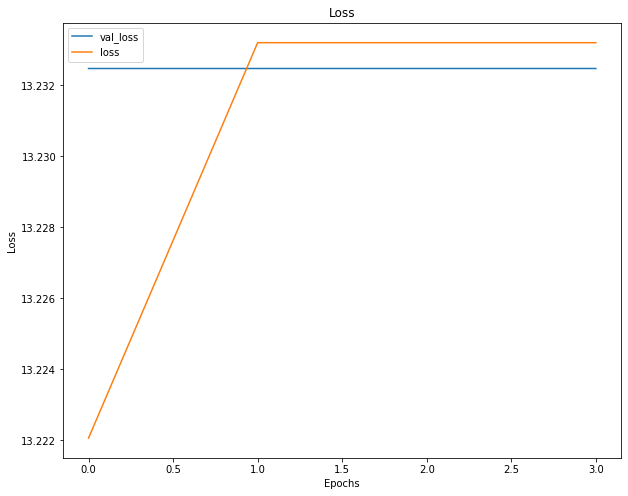

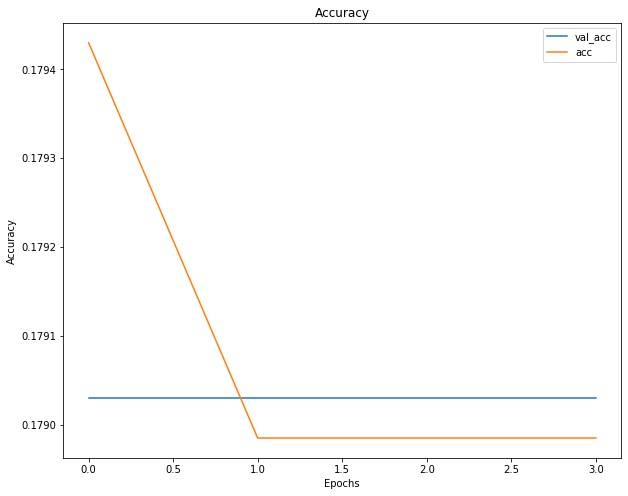

In [133]:
visualize_training_results(fsm_results)

In [134]:
fsm_results.history

{'val_loss': [13.23247352170196,
  13.232473456400438,
  13.232473653665453,
  13.232473587003483],
 'val_acc': [0.17902995731027932,
  0.1790299572252513,
  0.17902995728902232,
  0.1790299572252513],
 'loss': [13.222067534191101,
  13.233200328857476,
  13.233200379471002,
  13.23320033700999],
 'acc': [0.17943009795987597,
  0.17898486197950153,
  0.17898486201400113,
  0.1789848619901168]}

## Evaluation

So we see here that this fsm did quite terribly.  The results did not improve over the epochs - 1 epoch would have been sufficient for these results.  It is also noted that the validation set did not improve, or in fact, move at all.  

I will now do some EDA to explore my image dataset further and then continue to iterate upon this model by scaling the data generator, adding more layers and trying different layers other than Dense.  I will also tune the hyperparameters as appropriate. 